<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Double Pendulum Analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is my last on the Hamiltonian neural networks, now with the double pendulum. For simplicity, m1=m2=l2=l2 is set to 1, and g is set to 3 in the Hamiltonian
</p>

In [1]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl")
includet("NeuralNetwork.jl")
includet("Double_Pendulum_functions.jl")

  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
┌ Warning: skipping callee Main.:(var"#RK4_step#6") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328


In [10]:
l1=1
l2=1
m1=1
m2=1
g=3

#I create the training and testing data in the exact same manner as the simple pendulum
t, x_train,y_train = generate_data_double(grads_ideal_double_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_double_pend, min_e=2, max_e=5) |>f32
_, x_test, y_test = generate_data_double(grads_ideal_double_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_double_pend, min_e=2, max_e=3) |>f32

x_Train = reshape(x_train, 4, 30*25)
y_Train = reshape(y_train, 4, 30*25)

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (4×30 Matrix{Float32}, 4×30 Matrix{Float32},)

[ Info: Saved animation to /Users/aleksandersekkelsten/double_pendulum.gif


Plots.AnimatedGif("/Users/aleksandersekkelsten/double_pendulum.gif")
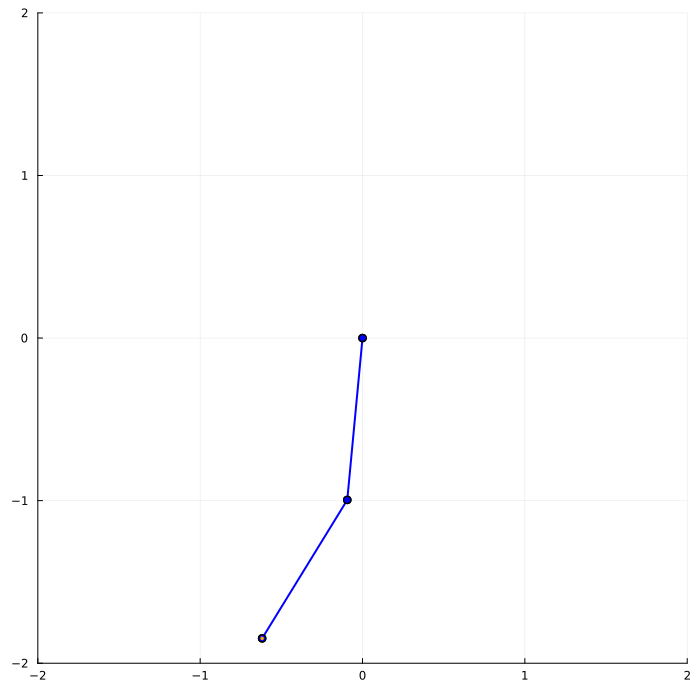

In [11]:
animate(x_train[:,:,5]) #Animating a random train-set

<h2 style="font-family:Times New Roman; font-size:200%">Conducting analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We will now train the HNN's with tanh, sigmoid, mish, swish and gelu, each with various gains=0.01,0.1,0.5,1,s^0.5,2 and 5. This is done for Kaiming, Glorot and Orthogonal weight initilization. The example presented here consists of 64 neurons, with one hidden layer. All models are trained with ADAM, learning rate of 0.001, 1200 epochs and random seed 2024. The pre-training scheme can be activated/de-activated by simply setting pretrain_double=true/false
</p>

In [5]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.1, .5, 1, 2^0.5, 5/3,2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]

MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))

    
    
Threads.@threads for a_idx in 1:length(activations)#for (a_idx, act) in enumerate(activations)
    act=activations[a_idx]
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        _, LuxH_k = models(4, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(4, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(4, 64, act, Orthogonal(g_val),1)

        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000, pretrain_double=true)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk

        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000, pretrain_double=true)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg

        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1000, pretrain_double=true)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso

    end
end

Doing gelu | Gain 5.0
Doing gelu | Gain 0.5
Doing tanh | Gain 0.1
Doing sigmoid | Gain 5.0
Doing gelu | Gain 0.1
Doing tanh | Gain 1.6666666666666667
Doing gelu | Gain 2.0
Doing sigmoid | Gain 0.1
Doing tanh | Gain 5.0
Doing mish | Gain 0.1
Doing swish | Gain 1.4142135623730951
Doing swish | Gain 2.0


┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Adjoint{Float64, Matrix{Float64}}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/wiiF1/src/impl/matmul.jl:145
┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Adjoint{Float64, Matrix{Float64}}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/wiiF1/src/impl/matmul.jl:145


Doing sigmoid | Gain 0.5
Doing mish | Gain 1.4142135623730951
Epoch=200 :loss = 2.0042899
Epoch=200 :loss = 0.2862811
Epoch=200 :loss = 0.06507693
Epoch=200 :loss = 0.11141308
Epoch=200 :loss = 0.047873322
Epoch=200 :loss = 0.048261974
Epoch=200 :loss = 0.23089138
Epoch=200 :loss = 0.04678937
Epoch=200 :loss = 0.034233306
Epoch=400 :loss = 0.46598345
Doing swish | Gain 1.6666666666666667
Doing mish | Gain 2.0
Epoch=400 :loss = 0.0302337
Epoch=400 :loss = 0.027439078
Doing swish | Gain 5.0
Epoch=400 :loss = 0.080565594
Epoch=400 :loss = 0.029696176
Epoch=400 :loss = 0.03238295
Epoch=600 :loss = 0.25257206
Epoch=200 :loss = 0.2918646
Epoch=600 :loss = 0.02424548
Doing swish | Gain 0.5
Epoch=600 :loss = 0.028234242
Epoch=600 :loss = 0.05022893
Epoch=600 :loss = 0.023216074
Epoch=800 :loss = 0.19246961
Epoch=800 :loss = 0.023037199
Epoch=800 :loss = 0.016511498
Epoch=800 :loss = 0.037866827
Epoch=200 :loss = 0.37692413
Epoch=1000 :loss = 0.123744205
Doing gelu | Gain 1.6666666666666667
Epo

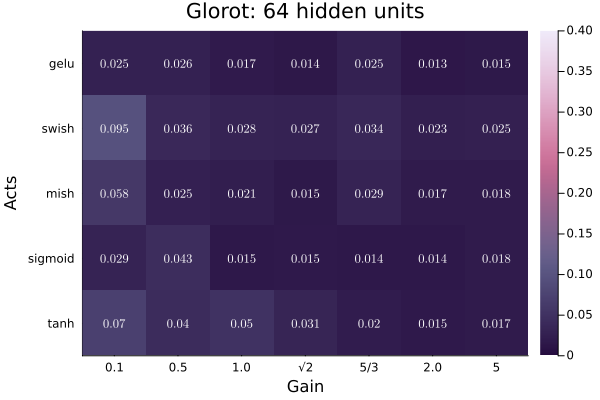

In [6]:
gain_str = ["0.1", "0.5", "1.0", "√2", "5/3","2.0", "5"]

hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units",
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white)) 
        for i in 1:length(activations) for j in 1:length(gains)])
hg 

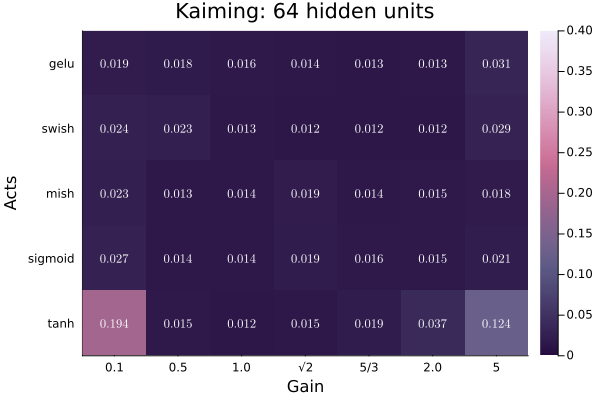

In [7]:

hk = heatmap(MSE_valsk, cmap=:acton,clim=(0, 0.4),title="Kaiming: 64 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white)) 
        for i in 1:length(activations) for j in 1:length(gains)])
hk 

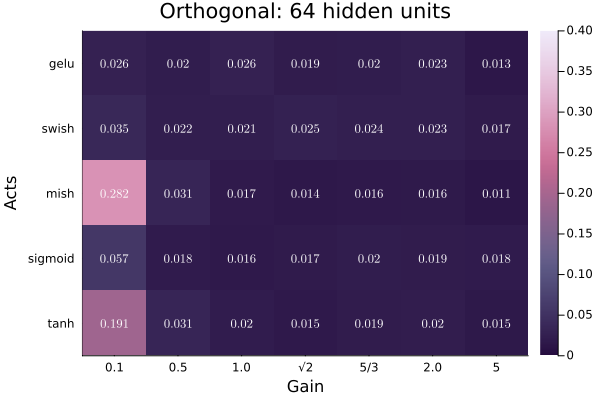

In [8]:
ho = heatmap(MSE_valso, cmap=:acton,clim=(0, 0.4),title="Orthogonal: 64 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white)) 
        for i in 1:length(activations) for j in 1:length(gains)])
ho 

<h2 style="font-family:Times New Roman; font-size:200%">Displaying results</h2>

<p style="font-family:Times New Roman; font-size:120%">
    In order to actually verify that the converging methods indeed converge, I add an animation here lastly showing the results of a random method converging.
</p>


In [45]:
_,hnn=models(4, 64, mish, Kaiming(0.5),3)
pHNN_k, sHNN_k = train_model(hnn, lossHNN, train_data, x_test, y_test;epochs=1000,lr=0.001,pretrain_double=true)
hnn = StatefulLuxLayer{true}(hnn, pHNN_k, sHNN_k)

Epoch=200 :loss = 0.03674382
Epoch=400 :loss = 0.0032596325
Epoch=600 :loss = 0.003953752
Epoch=800 :loss = 0.002987206
Epoch=1000 :loss = 0.0020308045


StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(4 => 64, mish),  # 320 parameters
        layer_2 = Dense(64 => 64, mish),  # 4_160 parameters
        layer_3 = Dense(64 => 64, mish),  # 4_160 parameters
        layer_4 = Dense(64 => 1),       # 65 parameters
    ),
)         # Total: 8_705 parameters,
          #        plus 0 states.

In [89]:
t, esth, _ = generate_data_double(simHNN, 1, 400, 20., sampler=sample_double_pend, model = hnn, min_e=4, max_e=5)
t, analk, _ = generate_data_double(grads_ideal_double_pend, 1, 400, 20., inits= esth[:,1])

(LinRange{Float64}(0.0, 20.0, 400), [-1.0696238917073844 -0.9868237362098895 … 0.005387047363218753 0.007162225947486042; 0.20361616460149845 0.12265761573697564 … 0.8033124239660585 0.9342817364827573; 2.708449677820308 2.7124575586418898 … 1.772224405138965 1.7749835380641206; -1.0541291593073865 -0.9541500946516824 … 2.69696895101347 2.5788436534542636], [1.5765083263379007 1.7410729163869387 … -0.07324281741910399 0.13862088772240566; -1.5163373471956194 -1.7291469338134995 … 2.7481066065910227 2.4956516367248467; 0.34559054074068773 -0.19303278285980086 … -0.1602585909680232 0.2552365863097432; 1.6788327313323412 2.328818868856125 … -2.0148822905969994 -2.6892401379199713])

[ Info: Saved animation to /Users/aleksandersekkelsten/double_pendulum.gif


Plots.AnimatedGif("/Users/aleksandersekkelsten/double_pendulum.gif")
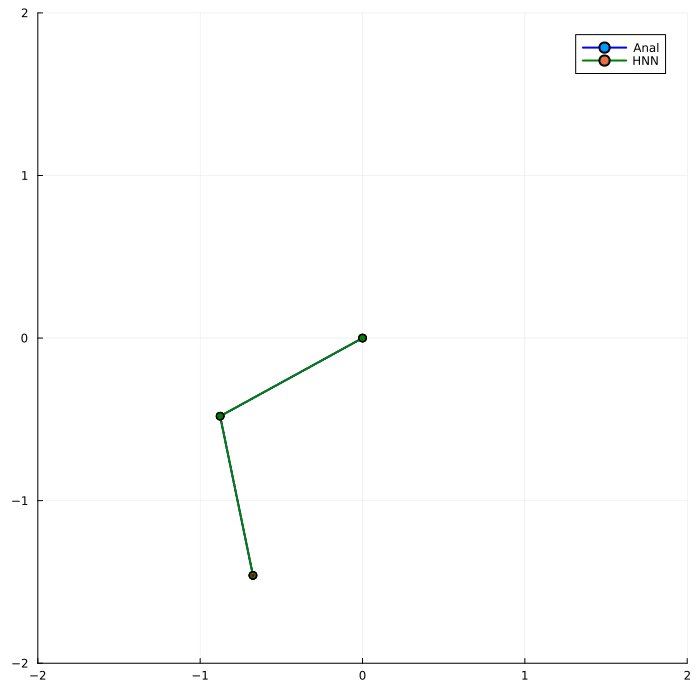

In [90]:
animate(analk, esth)